<a href="https://colab.research.google.com/github/dominikklepl/Neural-Networks-Intracranial-hemorrhage-detection/blob/master/03_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning

In [0]:
prototyping = True

## Setup and paths to data

Install missing packages

In [0]:
!pip install pydicom

Import all required packages

In [0]:
#connect google drive
from google.colab import drive

#dealing with zip
import zipfile

#importing labels and working with dataframe
import pandas as pd

#manipulation with images
import pydicom
import torch
import numpy as np
from math import ceil, floor, log
import cv2

#train-test
from sklearn.model_selection import train_test_split, StratifiedKFold

#models
%tensorflow_version 1.x
import keras.utils
import tensorflow as tf
print(tf.__version__)
from keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout
from keras.initializers import glorot_normal, he_normal
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from tensorflow.nn import sigmoid_cross_entropy_with_logits

#pretrained models
from keras_applications.resnet import ResNet50
from keras_applications.inception_v3 import InceptionV3

#plotting
import matplotlib.pyplot as plt

1.15.0


In [0]:
#ignore deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Check that GPU is available and that keras can use it.

In [0]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Connect Google Drive. That's where my data is stored.

In [0]:
GDRIVE_PATH = "/gdrive"
drive.mount(GDRIVE_PATH)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


Set paths to all required data

In [0]:
WORK_DIR = "/content/"
BASE_DIR = GDRIVE_PATH + "/My Drive/"
ZIP_PATH = BASE_DIR + "DICOMS/train_images.zip"
DF_PATH = BASE_DIR + "train_balanced.csv"
MODEL_CH_PATH = WORK_DIR + "channels_transfer.hdf5" #for saving learned weights
MODEL_F_PATH = WORK_DIR + "full_transfer.hdf5"
RESULT_PATH = BASE_DIR + "results/" #for saving performance of models
IMAGES_PATH = WORK_DIR + "img"

#if the model and results aren't created already, create them
!mkdir /gdrive/My\ Drive/models
!mkdir /gdrive/My\ Drive/results

#also create temporary folder in working directory for unzipping images
!mkdir /content/img

mkdir: cannot create directory ‘/gdrive/My Drive/models’: File exists
mkdir: cannot create directory ‘/gdrive/My Drive/results’: File exists
mkdir: cannot create directory ‘/content/img’: File exists


In [0]:
#get number of CPU cores
import multiprocessing
CORES = multiprocessing.cpu_count()
print(CORES)

2


Images are saved in a zip file. For easier and faster manipulation, let's extract them to a folder in the working directory that we created before ("/content/img")

In [0]:
img_archive = zipfile.ZipFile(ZIP_PATH)
%time img_archive.extractall(path=IMAGES_PATH)

CPU times: user 14min 44s, sys: 2min 43s, total: 17min 28s
Wall time: 23min 28s


### Load the csv with labels and metadata

In [0]:
train_df = pd.read_csv(DF_PATH)
train_df.sample(3)

,Unnamed: 0,Unnamed: 0.1,index,SOPInstanceUID,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,Rows,Columns,PixelSpacing,BitsAllocated,BitsStored,HighBit,PixelRepresentation,WindowCenter,WindowWidth,RescaleIntercept,RescaleSlope,fname,MultiImagePositionPatient,ImagePositionPatient1,ImagePositionPatient2,MultiImageOrientationPatient,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,pct_cut,split
12176,12176,12176,83719,ID_31022f246,CT,ID_6f7bf8dd,ID_bf87b12ae7,ID_dc73cd42ae,NaN,-125.0,1.0,1,MONOCHROME2,512,512,0.488281,16,16,15,1,40.0,150.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detectio...,1,-126.998,64.846000,1,0.0,0.0,0.0,0.93358,-0.358368,1,0.488281,-1024,2833,291.342323,880.239037,0.281250,NaN,NaN,NaN,NaN,1,0,1,0,0,1,"(0.2, 0.3]",2
95061,95061,95061,660827,ID_fe4342440,CT,ID_c5beae71,ID_4eccdbbe89,ID_689978fd0a,NaN,-125.0,1.0,1,MONOCHROME2,512,512,0.488281,16,16,15,1,40.0,150.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detectio...,1,-140.000,54.000000,1,0.0,0.0,0.0,1.00000,0.000000,1,0.488281,-1024,2875,242.978146,877.892348,0.222916,NaN,NaN,NaN,NaN,1,0,1,0,0,0,"(0.2, 0.3]",10
172795,172795,172795,565822,ID_002697199,CT,ID_5df12161,ID_888cbb8dde,ID_f0d609fda5,NaN,-128.5,1.0,1,MONOCHROME2,512,512,0.501953,16,12,11,0,36.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detectio...,1,-49.500,105.300049,1,0.0,0.0,0.0,1.00000,0.000000,1,0.501953,6,2269,350.803295,473.398135,0.091309,1.0,36.0,1.0,80.0,0,0,0,0,0,0,"(0.05, 0.1]",18


Some of the columns are useless at this point, let's keep just those that we actually need. Also some of the columns have too long name, yes SOPInstanceUID I'm talking about you so we'll rename them.

In [0]:
train = train_df[['SOPInstanceUID',
                  'PatientID',
                  'any',
                  'epidural',
                  'intraparenchymal',
                  'intraventricular',
                  'subarachnoid',
                  'subdural']].copy()
train.rename(columns={'SOPInstanceUID': 'ID',
                      'PatientID': 'Patient'},
              inplace=True)
#shuffle rows
train = train.sample(frac=1)
train = train.set_index('ID', drop=False)
train.head(5)

,ID,Patient,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
ID,,,,,,,,
ID_15230a8e4,ID_15230a8e4,ID_b801c428,1,0,0,0,0,1
ID_b8a25fd23,ID_b8a25fd23,ID_36a99844,1,0,1,0,0,1
ID_cd1d31de4,ID_cd1d31de4,ID_6f0e89d3,0,0,0,0,0,0
ID_99322d6c5,ID_99322d6c5,ID_568ac9b6,0,0,0,0,0,0
ID_701cff077,ID_701cff077,ID_0e95d11f,0,0,0,0,0,0


In [0]:
if prototyping:
  train = train.sample(200)

### Load bins for uniform transform

In [0]:
bins = torch.load(BASE_DIR+"bins.pt").numpy()

## Data processing functions
Before we can start building awesome neural networks, we need a few helper functions for constructing data (i.e. images) in form that's acceptable for the models to learn from.

First, functions for reading DICOM and applying intercept and slope.

In [0]:
#correcting dcm with wrong meta-data (explained in preprocessing notebook)
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

#transform dicom to HU by applying intercept and slope
def rescale_dcm(dcm):
  if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
    correct_dcm(dcm)
  return dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept

### Use full scale but apply uniform distribution

In [0]:
def to_full(dcm, bins):
  ys = np.linspace(0., 1., len(bins))
  x = dcm.flatten()
  x = np.interp(x, bins, ys)
  x = x.reshape(dcm.shape).clip(0.,1.) * 2**16
  x = x.astype(np.uint16)
  x[x<np.median(x)]=0
  x = np.stack((x,)*3, axis=-1)
  return x

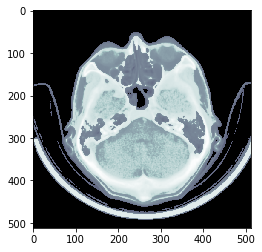

In [0]:
#test it
dcm = pydicom.dcmread(IMAGES_PATH+"/"+train.ID[0]+".dcm")
dcm = rescale_dcm(dcm)
x = to_full(dcm, bins)
plt.imshow(x[:,:,0], cmap=plt.cm.bone)

### Getting channels and save them as color channels

In [0]:
def window_image(img, window_center, window_width, U=1.0, eps=(1.0 / 255.0)):
    ue = np.log((U / eps) - 1.0)
    W = (2 / window_width) * ue
    b = ((-2 * window_center) / window_width) * ue
    z = W * img + b
    img = U / (1 + np.power(np.e, -1.0 * z))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

def to_channels(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)
    return bsb_img

In [0]:
#Finally function for loading a single image and resizing it to the input size.
def read_img(ID, resize, preprocess):
    path = IMAGES_PATH+'/'+ID+'.dcm'
    dcm = pydicom.dcmread(path)
    dcm = rescale_dcm(dcm)

    if preprocess is "CH":
      try: img = to_channels(dcm)
      except: img = np.zeros(resize)
    if preprocess is "F":
      try: img = to_full(dcm, bins)
      except: img = np.zeros(resize)

    img = cv2.resize(img, resize[:2], interpolation=cv2.INTER_CUBIC) #resize
    img = (img - np.min(img))/(np.max(img)-np.min(img)) #min-max normalize
    return img

CPU times: user 71.8 ms, sys: 1.04 ms, total: 72.9 ms
Wall time: 74.2 ms
CPU times: user 15 ms, sys: 0 ns, total: 15 ms
Wall time: 15 ms
(250, 250, 3)


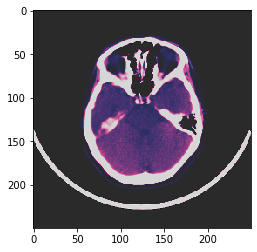

In [0]:
%time img_ch = read_img(train.ID[2], (250, 250, 3), preprocess="CH")
%time img_f = read_img(train.ID[2], (250, 250, 3), preprocess="F")

#some sanity checks
plt.imshow(img_ch)
print(img_ch.shape)

(250, 250, 3)


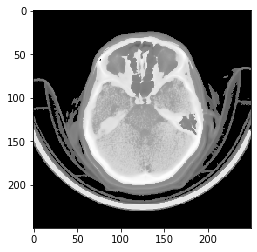

In [0]:
plt.imshow(img_f)

### Data generator
This function prepares each batch for feeding to neural network. First, it gets random IDs and associated labels. Then shuffles them, to reduce bias. Finally, the images, using the IDs are loaded using the _read function defined above.

The function is generalized for both training and testing data.

It is derived from keras.sequence so it should be enabled for multiprocessing.

#### Full-preprocessing DataGenerator

In [0]:
class DataGenerator_Full(keras.utils.Sequence):

    def __init__(self, IDs, labels=None, batch_size=30, img_size=(299, 299, 3), num_classes=5, *args, **kwargs):
        self.IDs = IDs
        self.labels = labels.loc[:, 'any':'subdural']
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.on_epoch_end()

#define number of steps per epoch
    def __len__(self):
        return int(ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        #indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        IDs_batch = self.IDs[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
          X, y_any, y_subtype = self.__data_generation(IDs_batch)
          return X, [y_any, y_subtype]
        else:
            X = self.__data_generation(IDs_batch)
            return X
        
    def on_epoch_end(self):
        if self.labels is not None: #during training we shuffle the images
            self.indices = np.arange(len(self.IDs))
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(self.IDs))

    def __data_generation(self, IDs_batch):
        X = np.empty((self.batch_size, *self.img_size))
        if self.labels is not None: # training
          y_subtype = np.empty((self.batch_size, self.num_classes), dtype=np.float32)
          y_any = np.empty((self.batch_size, 1), dtype=np.float32)
          for i, ID in enumerate(IDs_batch):
            X[i,] = read_img(ID, self.img_size, preprocess="F")
            y_any[i], y_subtype[i] = self.__get_target(ID)
            return X, y_any, y_subtype
        else: # testing
            for i, ID in enumerate(IDs_batch):
                X[i,] = read_img(ID, self.img_size, preprocess="F")
            return X

    def __get_target(self, ID):
        y_any = self.labels.loc[ID, "any"]
        y_subtype = self.labels.drop("any", axis=1).loc[ID].values
        return y_any, y_subtype

#### Channels-preprocessing DataGenerator

In [0]:
class DataGenerator_Channels(keras.utils.Sequence):

    def __init__(self, IDs, labels=None, batch_size=30, img_size=(299, 299, 3), num_classes=5, *args, **kwargs):
        self.IDs = IDs
        self.labels = labels.loc[:, 'any':'subdural']
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.on_epoch_end()

#define number of steps per epoch
    def __len__(self):
        return int(ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        #indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        IDs_batch = self.IDs[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
          X, y_any, y_subtype = self.__data_generation(IDs_batch)
          return X, [y_any, y_subtype]
        else:
            X = self.__data_generation(IDs_batch)
            return X
        
    def on_epoch_end(self):
        if self.labels is not None: #during training we shuffle the images
            self.indices = np.arange(len(self.IDs))
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(self.IDs))

    def __data_generation(self, IDs_batch):
        X = np.empty((self.batch_size, *self.img_size))
        if self.labels is not None: # training
          y_subtype = np.empty((self.batch_size, self.num_classes), dtype=np.float32)
          y_any = np.empty((self.batch_size, 1), dtype=np.float32)
          for i, ID in enumerate(IDs_batch):
            X[i,] = read_img(ID, self.img_size, preprocess="CH")
            y_any[i], y_subtype[i] = self.__get_target(ID)
            return X, y_any, y_subtype
        else: # testing
            for i, ID in enumerate(IDs_batch):
                X[i,] = read_img(ID, self.img_size, preprocess="CH")
            return X

    def __get_target(self, ID):
        y_any = self.labels.loc[ID, "any"]
        y_subtype = self.labels.drop("any", axis=1).loc[ID].values
        return y_any, y_subtype

## Loss functions and performance metrics

### Multilabel Loss

In [0]:
def np_multilabel_loss(y_true, y_pred, class_weights=np.array([2., 1., 1., 1., 1., 1.])):
    y_pred = np.where(y_pred > 1-(1e-07), 1-1e-07, y_pred)
    y_pred = np.where(y_pred < 1e-07, 1e-07, y_pred)
    single_class_cross_entropies = - np.mean(y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred), axis=0)
    
    print(single_class_cross_entropies)
    if class_weights is None:
        loss = np.mean(single_class_cross_entropies)
    else:
        loss = np.sum(class_weights*single_class_cross_entropies)
    return loss

In [0]:
class Transfer_network_F:
    
    def __init__(self, engine, loss_fun, metrics_list, input_dims, train_generator, val_generator,
                 epochs, learning_rate=1e-3, num_classes=5, checkpoint_path=MODEL_F_PATH, weights='imagenet'):
        
        self.engine = engine
        self.loss_fun = loss_fun
        self.metrics_list = metrics_list
        self.input_dims = input_dims
        self.train_generator = train_generator
        self.val_generator = val_generator
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.checkpoint_path = checkpoint_path
        self.weights = weights

        #args for saving trained weights at the epoch with best validation loss
        self.checkpoint = ModelCheckpoint(filepath=self.checkpoint_path,
                                          mode="min",
                                          verbose=1,
                                          save_best_only=True,
                                          save_weights_only=True,
                                          period=1)
        
        #when loss stops decresing, decrease learning rate
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                           factor=0.5,
                                           patience=2,
                                           min_lr=1e-8,
                                           mode="min")
        

        self.e_stopping = EarlyStopping(monitor="val_loss",
                                        min_delta=0.01,
                                        patience=5,
                                        mode="min",
                                        restore_best_weights=True)
        
    def build_model(self):
        transfer = self.engine(include_top=False, weights=self.weights, input_shape=self.input_dims,
                             backend = keras.backend, layers = keras.layers,
                             models = keras.models, utils = keras.utils)
        x = transfer.output
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.3)(x)
        x = Dense(100, activation="relu")(x)
        x = Dropout(0.3)(x)
        any_logits = Dense(1, kernel_initializer=he_normal(seed=11))(x)
        any_pred = Activation("sigmoid", name="any_predictions")(any_logits)
        x = concatenate([any_pred, x])
        sub_pred = Dense(self.num_classes,
                         name="subtype_pred",
                         kernel_initializer=he_normal(seed=12),
                         activation="sigmoid")(x) 
        self.model = Model(inputs=transfer.input, outputs=[any_pred, sub_pred])
    
    def compile_model(self):
      self.model.compile(optimizer=Adam(self.learning_rate),
                         loss=['binary_crossentropy', np_multilabel_loss],
                         loss_weights = [0.4, 0.6],
                         metrics=self.metrics_list)
    
    def learn(self):
        return self.model.fit_generator(generator=self.train_generator,
                    validation_data=self.val_generator,
                    epochs=self.epochs,
                    callbacks=[self.checkpoint, self.reduce_lr, self.e_stopping],
                    use_multiprocessing=False,
                    workers=CORES)
    
    def load_weights(self, path):
        self.model.load_weights(path)
    
    def predict(self, data_generator):
        predictions = self.model.predict_generator(data_generator, workers=CORES)
        return predictions

class Transfer_network_CH:
    
    def __init__(self, engine, loss_fun, metrics_list, input_dims, train_generator, val_generator,
                 epochs, learning_rate=1e-3, num_classes=5, checkpoint_path=MODEL_CH_PATH, weights='imagenet'):
        
        self.engine = engine
        self.loss_fun = loss_fun
        self.metrics_list = metrics_list
        self.input_dims = input_dims
        self.train_generator = train_generator
        self.val_generator = val_generator
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.checkpoint_path = checkpoint_path
        self.weights = weights

        #args for saving trained weights at the epoch with best validation loss
        self.checkpoint = ModelCheckpoint(filepath=self.checkpoint_path,
                                          mode="min",
                                          verbose=1,
                                          save_best_only=True,
                                          save_weights_only=True,
                                          period=1)
        
        #when loss stops decresing, decrease learning rate
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                           factor=0.5,
                                           patience=2,
                                           min_lr=1e-8,
                                           mode="min")
        

        self.e_stopping = EarlyStopping(monitor="val_loss",
                                        min_delta=0.01,
                                        patience=5,
                                        mode="min",
                                        restore_best_weights=True)
        
    def build_model(self):
        transfer = self.engine(include_top=False, weights=self.weights, input_shape=self.input_dims,
                             backend = keras.backend, layers = keras.layers,
                             models = keras.models, utils = keras.utils)
        x = transfer.output
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.3)(x)
        x = Dense(100, activation="relu")(x)
        x = Dropout(0.3)(x)
        any_logits = Dense(1, kernel_initializer=he_normal(seed=11))(x)
        any_pred = Activation("sigmoid", name="any_predictions")(any_logits)
        x = concatenate([any_pred, x])
        sub_pred = Dense(self.num_classes,
                         name="subtype_pred",
                         kernel_initializer=he_normal(seed=12),
                         activation="sigmoid")(x) 
        self.model = Model(inputs=transfer.input, outputs=[any_pred, sub_pred])
    
    def compile_model(self):
      self.model.compile(optimizer=Adam(self.learning_rate),
                         loss=['binary_crossentropy', np_multilabel_loss],
                         loss_weights = [0.4, 0.6],
                         metrics=self.metrics_list)
    
    def learn(self):
        return self.model.fit_generator(generator=self.train_generator,
                    validation_data=self.val_generator,
                    epochs=self.epochs,
                    callbacks=[self.checkpoint, self.reduce_lr, self.e_stopping],
                    use_multiprocessing=False,
                    workers=CORES)
    
    def load_weights(self, path):
        self.model.load_weights(path)
    
    def predict(self, data_generator):
        predictions = self.model.predict_generator(data_generator, workers=CORES)
        return predictions

## Train-val split

In [0]:
split_seed = 1
kfold = StratifiedKFold(n_splits=2, random_state=split_seed).split(np.arange(train.shape[0]), train["any"].values)

train_idx, dev_idx = next(kfold)

train_data = train.iloc[train_idx]
val_data = train.iloc[dev_idx]

print(train_data.shape)
print(val_data.shape)

Train model

In [0]:
train_dataloader_CH = DataGenerator_Channels(IDs=train_data.ID,
                                 labels=train_data.loc[:,'any':'subdural'],
                                 batch_size=30,
                                 img_size=(200,200,3),
                                 num_classes=5)
val_dataloader_CH = DataGenerator_Channels(IDs=val_data.ID,
                               labels=val_data.loc[:,'any':'subdural'],
                               batch_size=5,
                               img_size=(200,200,3),
                               num_classes=5)

train_dataloader_F = DataGenerator_Full(IDs=train_data.ID,
                                 labels=train_data.loc[:,'any':'subdural'],
                                 batch_size=30,
                                 img_size=(200,200,3),
                                 num_classes=5)
val_dataloader_F = DataGenerator_Full(IDs=val_data.ID,
                               labels=val_data.loc[:,'any':'subdural'],
                               batch_size=5,
                               img_size=(200,200,3),
                               num_classes=5)

In [0]:
#sanity check of datagenerator
%time X, [y1, y2] = train_dataloader_CH.__getitem__(0)

In [0]:
print(X.shape)
print(y1.shape)
print(y2.shape)

In [0]:
model_CH = Transfer_network_CH(engine=InceptionV3, loss_fun=None,
                         metrics_list={"any_predictions":"binary_crossentropy",
                                       "subtype_pred": "binary_crossentropy"},
                         input_dims=(200,200,3),
                         train_generator=train_dataloader_CH,
                         val_generator=val_dataloader_CH,
                         epochs=2,
                         learning_rate=1e-3) 
model_CH.build_model()
model_CH.compile_model()
history_CH = model_CH.learn()

In [0]:
model_F = Transfer_network_F(engine=InceptionV3, loss_fun=None,
                         metrics_list={"any_predictions":"binary_crossentropy",
                                       "subtype_pred": "binary_crossentropy"},
                         input_dims=(200,200,3),
                         train_generator=train_dataloader_F,
                         val_generator=val_dataloader_F,
                         epochs=2,
                         learning_rate=1e-3) 
model_F.build_model()
model_F.compile_model()
history_F = model_F.learn()

In [0]:
#save weights to google drive
!cp channels_transfer.hdf5 /gdrive/My\ Drive/models

In [0]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].plot(history_CH.history["loss"], 'o-')
ax[0].plot(history_CH.history["val_loss"], 'o-')
ax[1].plot(history_CH.history["lr"], 'o-')